# DATA 643: Recommender Systems
Final Project:  Book Crossing RecSys | Walt Wells, Summer 2017

# Notebook P5 - Recommendations 

# Environment Prep

In [1]:
suppressMessages(library(clusteval))
suppressMessages(library(jpeg))

source('helper.R')

# Data Import

In [2]:
clustered <- readRDS("clusteredPreds.rds")
indexBook <- readRDS("indexBook.rds")

# User Choice

Let's simulate a situation where we give a user 5 choices to learn more about their preferences, to help solve the coldstart problem.   More effort would likely to be necessary to choice the best books to offer to gain the most information about which responses will best associate a user with a given cluster.

In [3]:
set.seed(643)
samp <- sample(ncol(clustered$binary), 5)
coldstart <- rep(FALSE, length.out=ncol(clustered$binary))
coldstart[samp] <- TRUE

## Calculate Similarity

We will use Jaccard Similarity to compare our user to our clustered users. 

In [4]:
getJaccardSimilarity <- function(user) {
    # given a sample user, calculate similarity to all other clusters
    scorelist <- list()
    for (i in 1:nrow(clustered$binary)) {
        score <- cluster_similarity(coldstart, clustered$binary[i,], similarity = "jaccard")
        scorelist[[i]] <- score
    }
    df <- data.frame(unlist(scorelist))
    df$index <- c(1:nrow(clustered$binary))
    names(df) <- c("jacc", "index")
    sorted_df <- df[order(-df$jacc, -df$index),]
    sorted_df
}

In [5]:
jaccDF <- getJaccardSimilarity(coldstart)

In [6]:
jaccDF
SampleUser <- jaccDF[1,2] ## This is what we'll use to test our Recommender later

,jacc,index
12,0.9980406,12
11,0.9980406,11
3,0.9977141,3
2,0.9977141,2
8,0.9951020,8
9,0.9941226,9
4,0.9928168,4
7,0.9905320,7
1,0.9836794,1
5,0.9810697,5


# Make Recommendations

## Get Recommendation Function

We'll try and add a little variety or serendipity, returning to the user the top 2, 5, 20 of from their most similar cluster.  The getThree function has a flag that if serendipity=F will instead return just the top 3 predictions.

In [7]:
getThree <- function(clusterNum, serendipity=TRUE) {
    # given the cluster representative most similar, return 3 recommendations.  
    vec <- t(t(clustered$predicted[clusterNum,]))
    sorted_vec <- vec[order(-vec),]
    rec <- data.frame(head(sorted_vec, 20))
    rec$ISBN <- rownames(rec)

    names(rec) <- c("Prediction", "ISBN")
    if (serendipity) {
        rec <- rec[c(2,5,20),] ## Variety!
        } else {
        rec <- rec[c(1,2,3), ]
        }
    rownames(rec) <- NULL
    rec
}

In [8]:
getThree(8)
getThree(8, serendipity = F)

Prediction,ISBN
0.004458608,0345370775
0.003981061,0440206154
0.002823913,0812550706


Prediction,ISBN
0.009782184,0316666343
0.004458608,0345370775
0.004243754,044021145X


In [9]:
getBooks <- function(three) {
    # return relevent information for recommendations
    df <- data.frame()
    for (i in three$ISBN) {
        vec <- indexBook[indexBook$ISBN == i,]
        vec <- vec[ , c("Book.Title","Book.Author", "Image.URL.L")]
        df <- rbind(df,vec)
    }
    df   
}

In [10]:
getBooks(getThree(8))
getBooks(getThree(8, F))

,Book.Title,Book.Author,Image.URL.L
1196,Jurassic Park,Michael Crichton,http://images.amazon.com/images/P/0345370775.01.LZZZZZZZ.jpg
1195,Red Dragon,Thomas Harris,http://images.amazon.com/images/P/0440206154.01.LZZZZZZZ.jpg
2233,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,http://images.amazon.com/images/P/0812550706.01.LZZZZZZZ.jpg


,Book.Title,Book.Author,Image.URL.L
409,The Lovely Bones: A Novel,Alice Sebold,http://images.amazon.com/images/P/0316666343.01.LZZZZZZZ.jpg
1196,Jurassic Park,Michael Crichton,http://images.amazon.com/images/P/0345370775.01.LZZZZZZZ.jpg
457,The Firm,John Grisham,http://images.amazon.com/images/P/044021145X.01.LZZZZZZZ.jpg


In [11]:
plotRec <- function(threebooks) {
    # given a booklist, show images associated with recommendations
    piclist <- list()
    booklist <- list()
    
    getpic <- function(myurl){
            # get image at url, close jpg
            z <- tempfile()
            download.file(myurl,z,mode="wb")
            pic <- readJPEG(z)
            file.remove(z)
            pic
        }
    
    for (i in 1:nrow(threebooks)){
        myurl <- paste0(threebooks[i,3])
        piclist[[i]] <- getpic(myurl)
        booklist[[i]] <- paste0(threebooks[i,1])
        }
    
    plot(1:7,ty="n", ann=FALSE, axes=FALSE, frame.plot=T)
    tryCatch(rasterImage(piclist[[2]],1,1,3,4.5),
        error = function(e){text(x=3, y=5, labels=paste0("ImageNotFound \n", booklist[[2]]))})   
    tryCatch(rasterImage(piclist[[3]],3,2,5,5.5), 
        error = function(e){text(x=4, y=5, labels=paste0("ImageNotFound \n", booklist[[3]]))})
    tryCatch(rasterImage(piclist[[1]],5,3,7,6.5),
        error = function(e){text(x=5, y=7, labels=paste0("ImageNotFound \n", booklist[[1]]))})
    text(x=4, y=7, labels="Recommended for you")
}

## Some examples

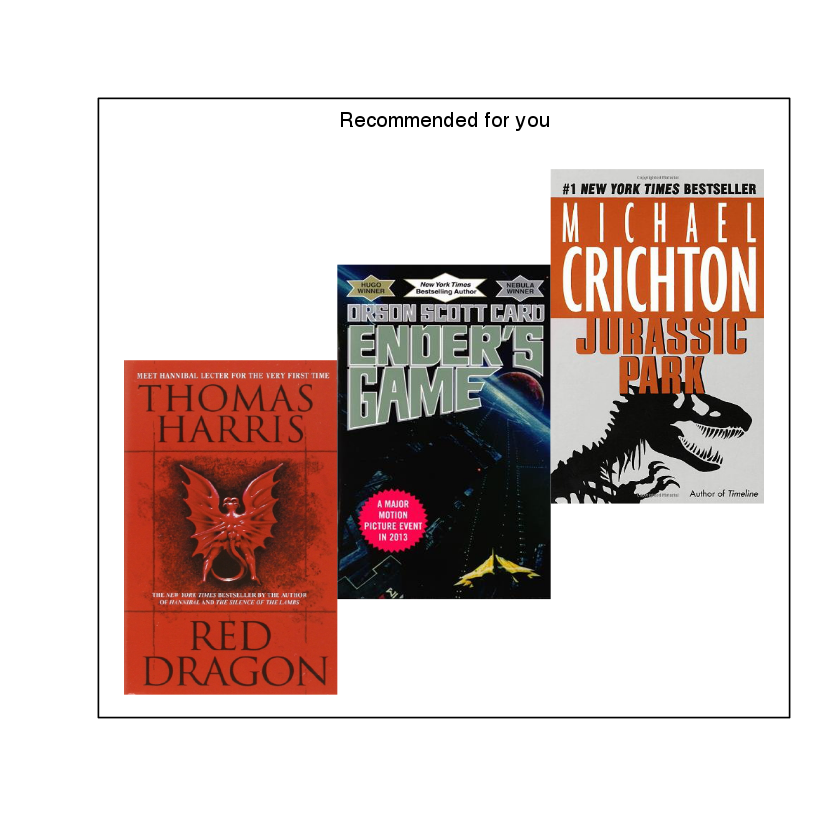

In [12]:
plotRec(getBooks(getThree(8)))

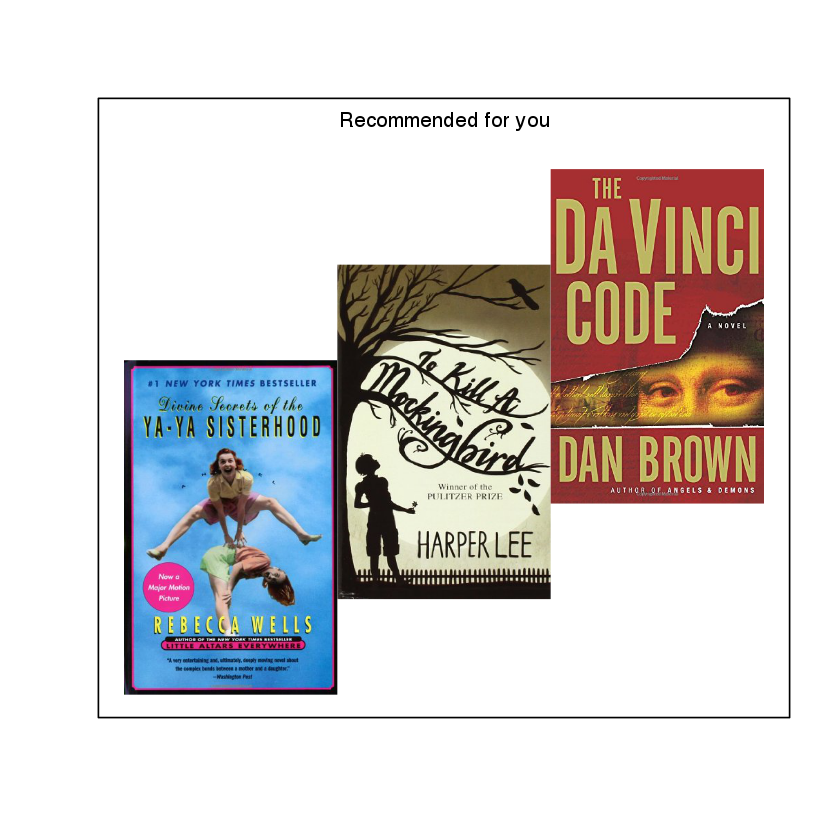

In [13]:
plotRec(getBooks(getThree(4)))

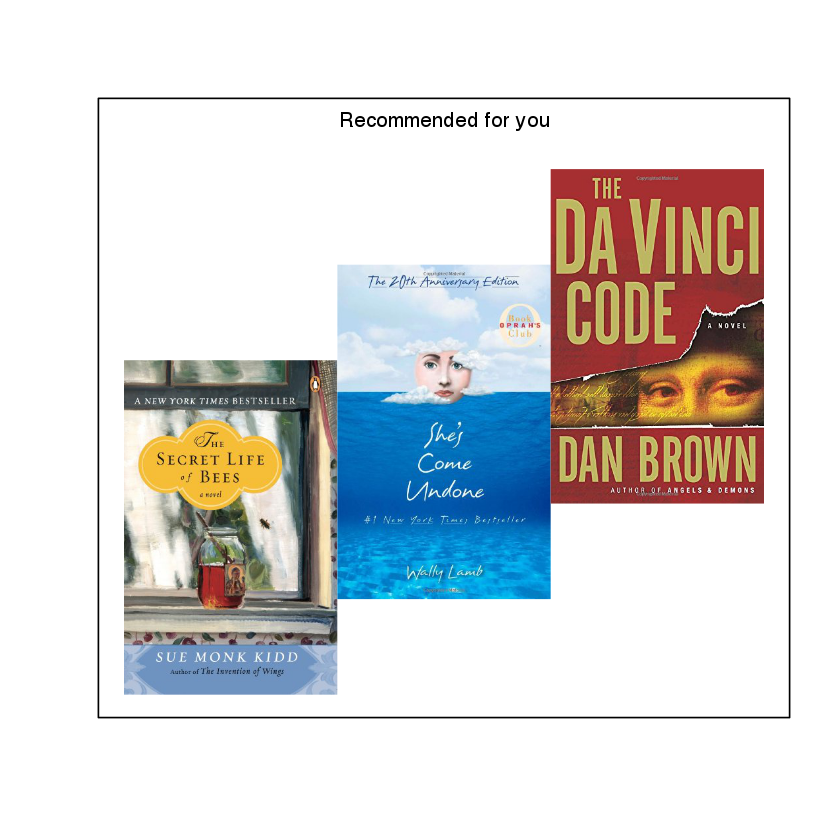

In [14]:
plotRec(getBooks(getThree(2)))

# Make Recommendation for ColdStart User

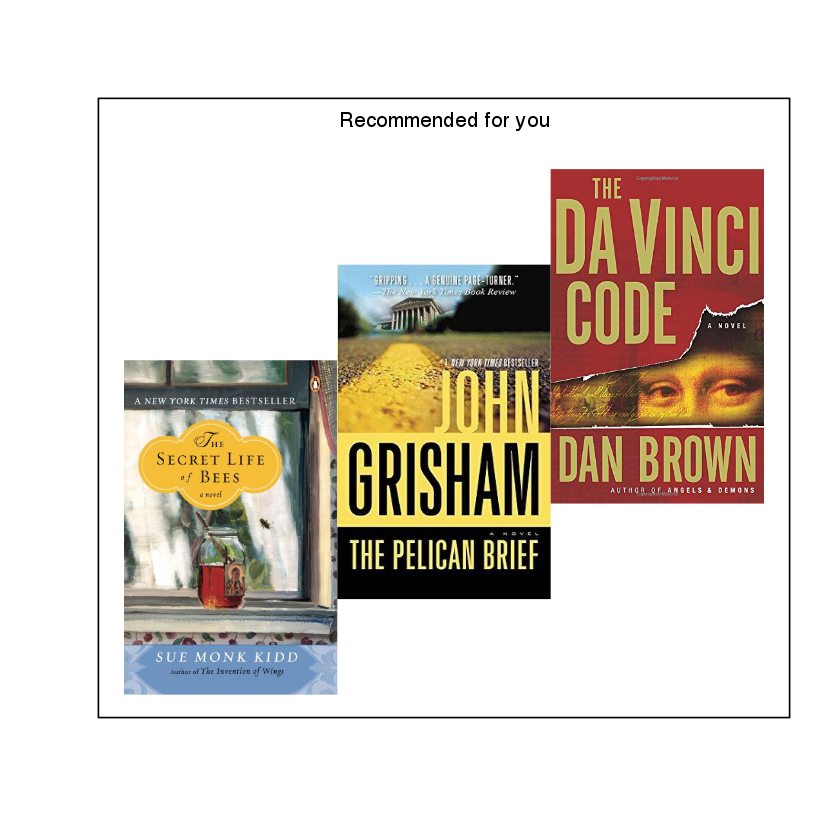

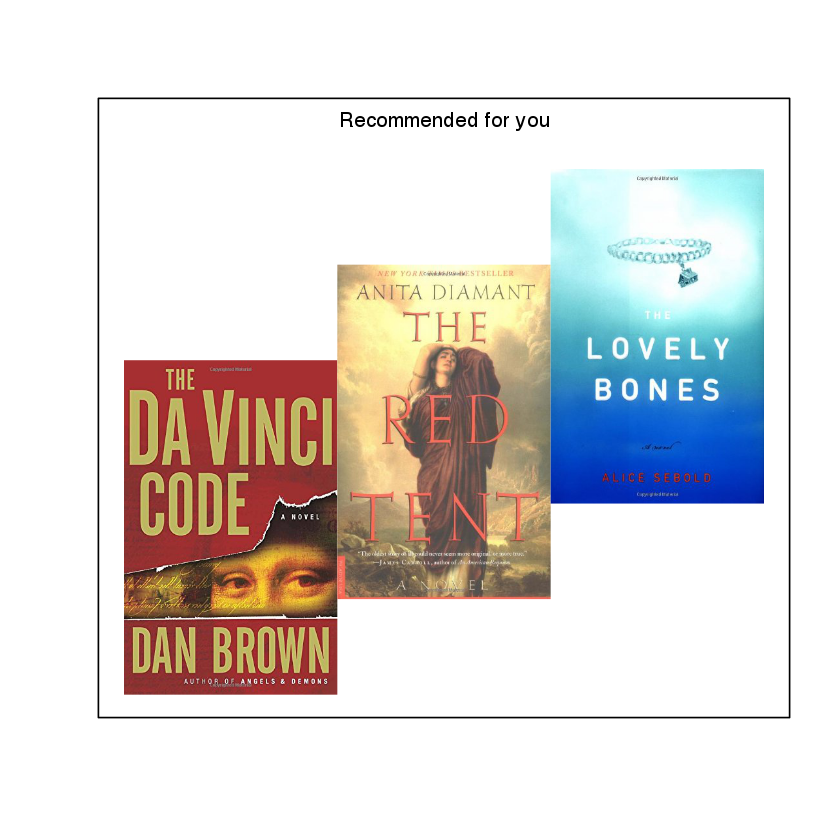

In [15]:
plotRec(getBooks(getThree(SampleUser)))
plotRec(getBooks(getThree(SampleUser, serendipity=F))) #just return top 3